In [ ]:
 %pip install -U qiskit "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

In [1]:
import qiskit
import qc_grader

print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'TjsUi7FnctBL0cYkFsJAMNHrGJkb4Pj7Dn4Ct71RTUX9',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/0a47d07759a4490eb699bc3560c10e9b:7e0cbe99-6ea4-4ff0-889e-2db9b7a600e9::',
  'verify': True,
  'private_endpoint': False}}

In [3]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

### Exercise 1: Find the best qubits

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import CouplingMap

def find_best_metrics(backend: QiskitRuntimeService.backend) -> list[tuple[int or list, float]]:
    """Finds the best-performing qubits and qubit pair based on various hardware metrics."""
    
    # Obtain the system properties and number of qubits
    properties = backend.properties()
    num_qubits = backend.num_qubits
    
    # Convert the CouplingMap object to a list of edges for easy indexing
    coupling_map_list = backend.coupling_map.get_edges()
    
    # Define metrics lists for the backend
    t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
    
    # Retrieve and store properties for all single qubits
    for i in range(num_qubits):
        t1.append(properties.t1(i))
        t2.append(properties.t2(i))
        gate_error_x.append(properties.gate_error("x", qubits=i))
        readout_error.append(properties.readout_error(i))
    
    # Retrieve and store properties for all two-qubit pairs using the list
    for pair in coupling_map_list:
        gate_error_ecr.append(properties.gate_error("ecr", qubits=pair))
        
    # Find the best qubit (index_t1_max) with the Longest T1 and its value (max_t1)
    max_t1 = max(t1)
    index_t1_max = t1.index(max_t1)

    # Find the best qubit (index_t2_max) with the Longest T2 and its value (max_t2)
    max_t2 = max(t2)
    index_t2_max = t2.index(max_t2)

    # Find the best qubit (index_min_x_error) with the smallest x gate error and its value (min_x_error)
    min_x_error = min(gate_error_x)
    index_min_x_error = gate_error_x.index(min_x_error)

    # Find the best qubit (index_min_readout) with the smallest readout error and its value (min_readout)
    min_readout = min(readout_error)
    index_min_readout = readout_error.index(min_readout)

    # Find the best qubit pair with minimum ECR error (min_ecr_pair) and its value (min_ecr_error)
    min_ecr_error = min(gate_error_ecr)
    # Use the list of pairs for indexing to find the corresponding qubit pair
    min_ecr_pair = coupling_map_list[gate_error_ecr.index(min_ecr_error)]

    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    
    return solutions

In [5]:
grade_lab2_ex1(find_best_metrics)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# 2. The problem: Max-cut

## 2.1 The problem: Define the graph

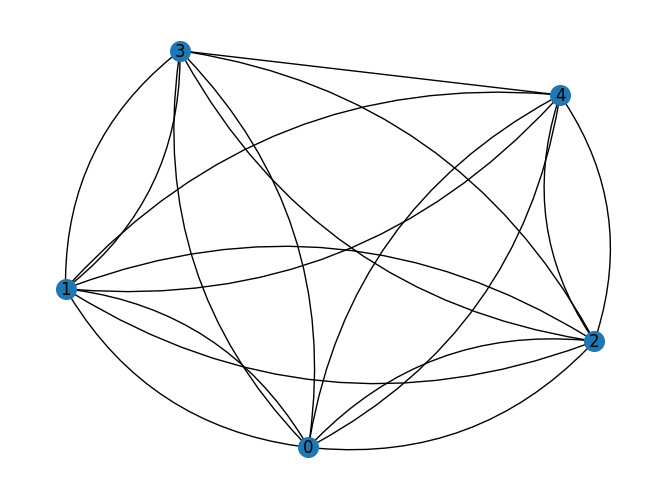

In [6]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

### Exercise 2: From Graph to Hamiltonian

In [7]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []
    
    # --- TODO: Task 2 ---
    # Goal: Convert the graph into a list like: [('PauliWord_1', weight_1), ('PauliWord_2', weight_2),...]
    
    num_qubits = graph.num_nodes()
    
    # Iterate over each edge in the graph
    for u, v in graph.edge_list():
        # Create a list representing the Pauli operators for each qubit
        pauli_term = ['I'] * num_qubits
        
        # Apply a Pauli-Z operator on the qubits connected by the edge
        pauli_term[u] = 'Z'
        pauli_term[v] = 'Z'
        
        # Qiskit's convention orders qubits from right to left (qubit 0 is the rightmost)
        # We reverse the list to create the correct Pauli string
        pauli_string = "".join(reversed(pauli_term))
        
        # For an unweighted Max-Cut problem, the weight for each term is 1.0
        weight = 1.0
        
        # Append the (Pauli string, weight) tuple to the list
        pauli_list.append((pauli_string, weight))
        
    # --- End of TODO ---
    
    return pauli_list

# Example Usage (assuming a 'graph' object already exists)
# -----------------------------------------------------------
# Create a sample graph for demonstration:
# A simple triangle graph with 3 nodes and 3 edges
graph = rx.PyGraph()
graph.add_nodes_from([0, 1, 2])
graph.add_edges_from([(0, 1, 1), (1, 2, 1), (0, 2, 1)])

# Convert the graph to a Pauli list
max_cut_paulis = graph_to_Pauli(graph)

# Create the cost Hamiltonian from the Pauli list
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)

print("Cost Function Hamiltonian:")
print(cost_hamiltonian)

Cost Function Hamiltonian:
SparsePauliOp(['IZZ', 'ZZI', 'ZIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


In [8]:
grade_lab2_ex2(graph_to_Pauli)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


## 2.3 QAOA solution

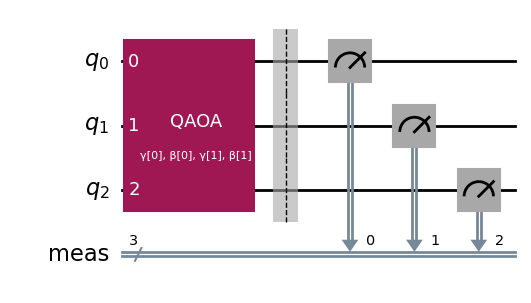

In [9]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

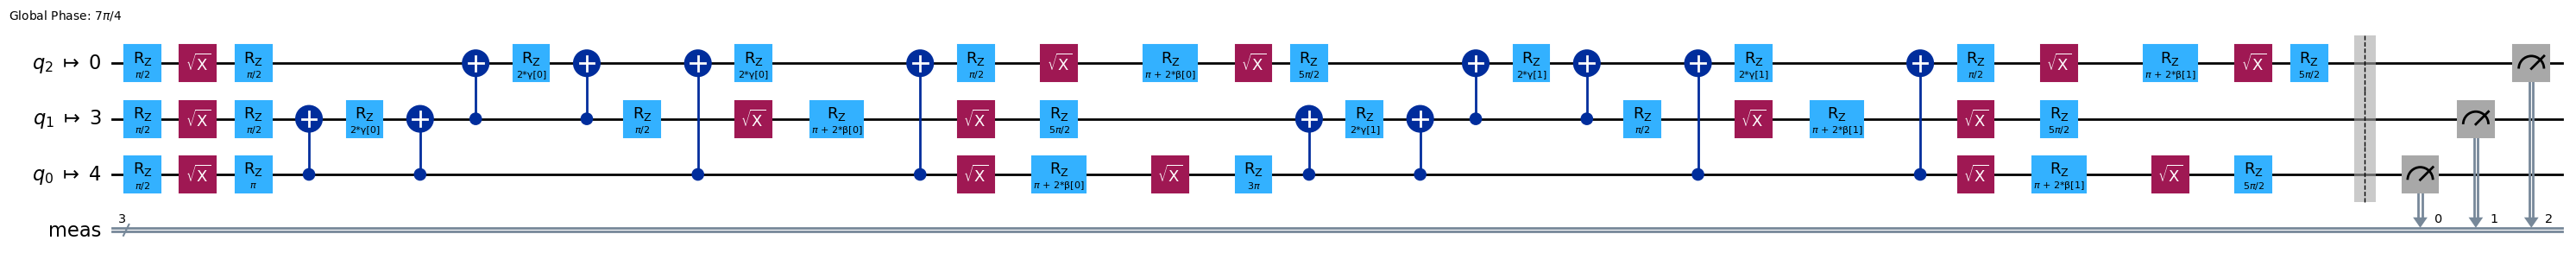

In [10]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

In [11]:
init_params = np.zeros(2 * layers)

In [12]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.968280317196828
       x: [ 9.605e-01  1.244e+00 -2.827e-02  2.799e-01]
    nfev: 48
   maxcv: 0.0


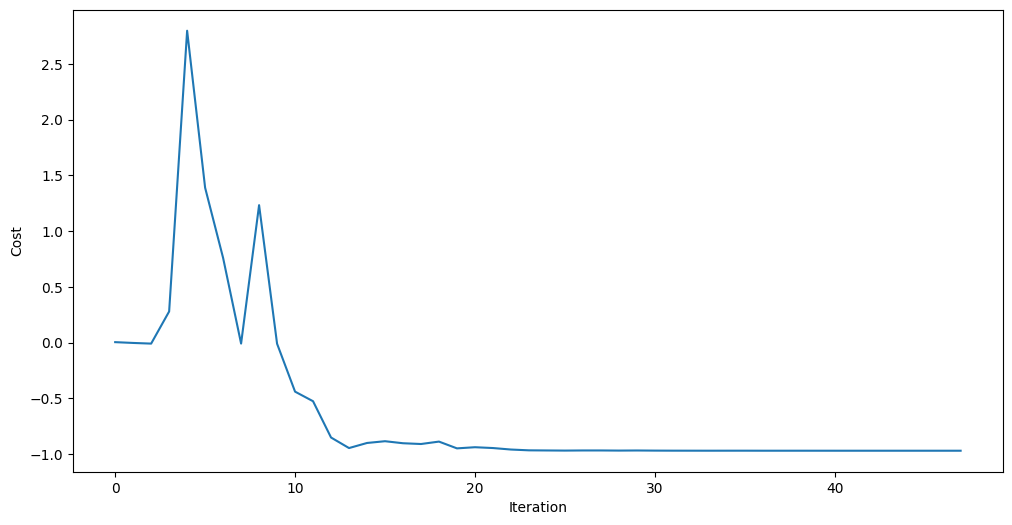

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

## 2.4 Checking our solution

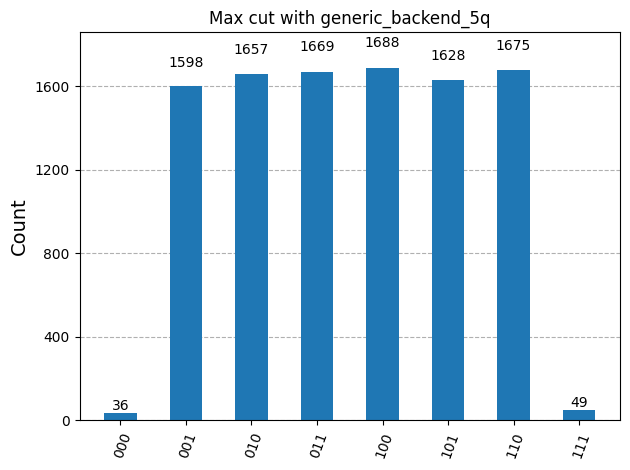

In [14]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -1.0
The number of solutions of the problem is 6
The list of the solutions based on their index is [1, 2, 3, 4, 5, 6]


In [16]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00001', '00010', '00011', '00100', '00101', '00110']
The QAOA ground states solutions for the Max-cut are: ['001', '010', '011', '100', '101', '110']


# 3. Noisy quantum simulator

## 3.1 Choosing the backend

In [17]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [18]:
# backends=[service.backend("alt_brisbane"),service.backend("alt_kawasaki"),service.backend("alt_torino")]
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]

In [19]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'ecr', 'measure', 'id', 'x', 'sx']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'ecr', 'measure', 'id', 'x', 'sx']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'cz', 'measure', 'id', 'x', 'sx']>)]


### Exercise 3: Error Counting

In [20]:
def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""
    
    # Initializing quantities
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

    # Defining useful variables
    properties = backend.properties()

    # TODO: Define readout error (only for qubits in qubit_layout) using `properties.readout_error`
    # Only count readout errors for qubits that are actually measured
    for instruction in circuit.data:
        if instruction.operation.name == 'measure':
            qubit = instruction.qubits[0]
            # Get the qubit index - try different attributes
            if hasattr(qubit, 'index'):
                qubit_index = qubit.index
            elif hasattr(qubit, '_index'):
                qubit_index = qubit._index
            else:
                continue  # Skip if we can't get the index
            try:
                acc_readout_error += properties.readout_error(qubit_index)
            except:
                pass

    # TODO: Define two qubit gates for the different backends using `backend.configuration()`
    basis_gates = backend.configuration().basis_gates
    if "ecr" in basis_gates:
        two_qubit_gate = "ecr"
    elif "cz" in basis_gates:
        two_qubit_gate = "cz"
    else:
        two_qubit_gate = "cx"  # fallback to cx if neither ecr nor cz available

    # TODO: Loop over the instructions in `circuit.data` to account for the single and two-qubit errors
    for instruction in circuit.data:
        if len(instruction.qubits) == 1:  # Single qubit gate
            # Count and add errors for single qubit gates
            single_qubit_gate_count += 1
            qubit = instruction.qubits[0]
            
            # Get the qubit index - try different attributes
            if hasattr(qubit, 'index'):
                qubit_index = qubit.index
            elif hasattr(qubit, '_index'):
                qubit_index = qubit._index
            else:
                continue  # Skip if we can't get the index
            
            # Get the gate name
            gate_name = instruction.operation.name
            
            # Add the gate error for this specific gate on this specific qubit
            try:
                gate_error = properties.gate_error(gate_name, qubit_index)
                acc_single_qubit_error += gate_error
            except:
                pass
            
        elif len(instruction.qubits) == 2:  # Two qubit gate
            # Count and add errors for two qubit gates
            two_qubit_gate_count += 1
            qubit0 = instruction.qubits[0]
            qubit1 = instruction.qubits[1]
            
            # Get qubit indices - try different attributes
            if hasattr(qubit0, 'index'):
                qubit0_index = qubit0.index
            elif hasattr(qubit0, '_index'):
                qubit0_index = qubit0._index
            else:
                continue
                
            if hasattr(qubit1, 'index'):
                qubit1_index = qubit1.index
            elif hasattr(qubit1, '_index'):
                qubit1_index = qubit1._index
            else:
                continue
            
            # Use the backend's native two-qubit gate for error lookup
            try:
                gate_error = properties.gate_error(two_qubit_gate, [qubit0_index, qubit1_index])
                acc_two_qubit_error += gate_error
            except:
                pass

    # Calculate total accumulated error
    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    
    # Return results
    results = [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]
    return results

In [21]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# You can print your results to visualize if they are correct
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 18 gates: 0.093
Accumulated one-qubit error of 129 gates: 0.011
Accumulated readout error: 0.026
Accumulated total error: 0.130

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 18 gates: 0.054
Accumulated one-qubit error of 131 gates: 0.007
Accumulated readout error: 0.036
Accumulated total error: 0.097

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 18 gates: 0.050
Accumulated one-qubit error of 82 gates: 0.018
Accumulated readout error: 0.016
Accumulated total error: 0.084



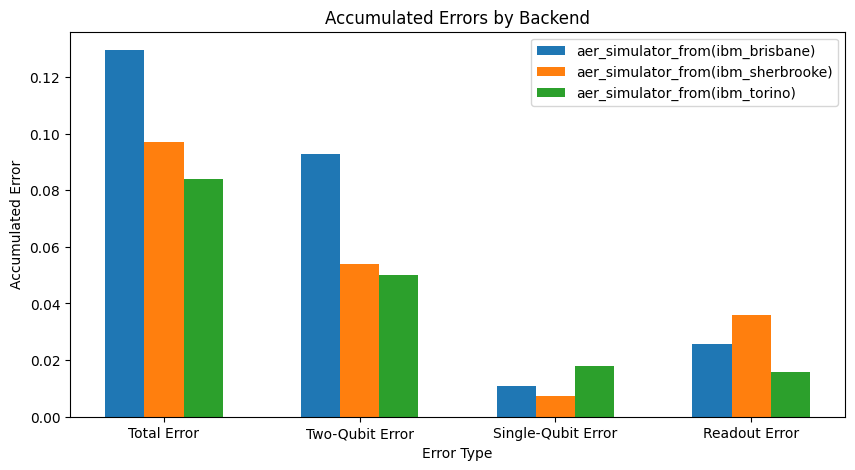

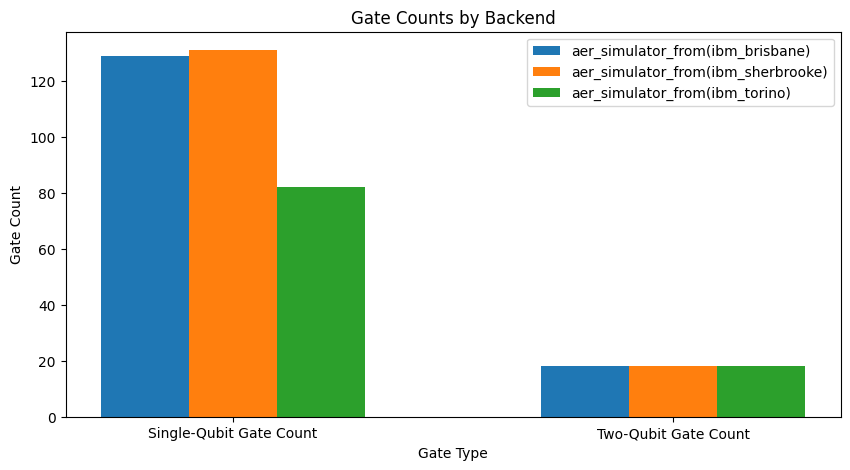

In [22]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [23]:
grade_lab2_ex3(accumulated_errors)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.8900010999890001
       x: [ 9.926e-01  1.249e+00 -1.339e-02  2.970e-01]
    nfev: 50
   maxcv: 0.0


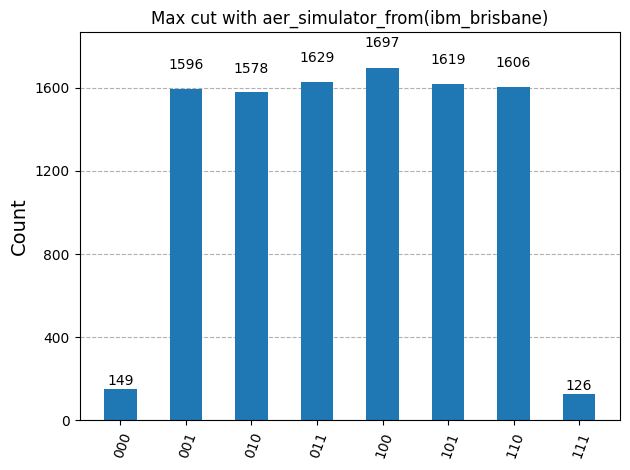

In [24]:
opt_params_list = []
counts_list_backends = []
for noisy_fake_backend, circuit in zip(noisy_fake_backends[:1], qaoa_transpiled_list[:1]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.8968810311896881
       x: [ 9.857e-01  1.252e+00 -1.084e-02  2.966e-01]
    nfev: 44
   maxcv: 0.0


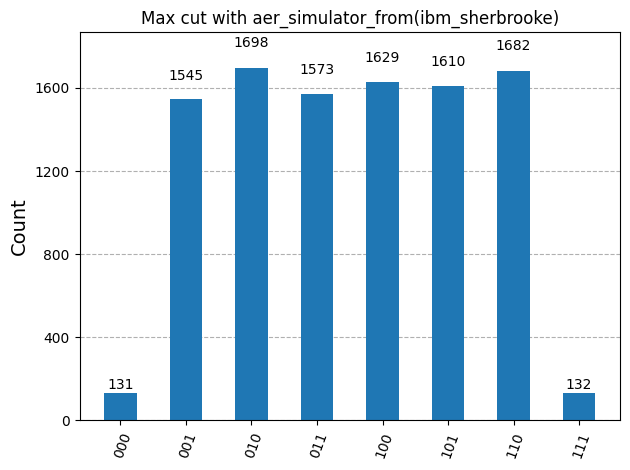

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.9242407575924241
       x: [ 9.862e-01  1.251e+00 -1.148e-02  2.968e-01]
    nfev: 42
   maxcv: 0.0


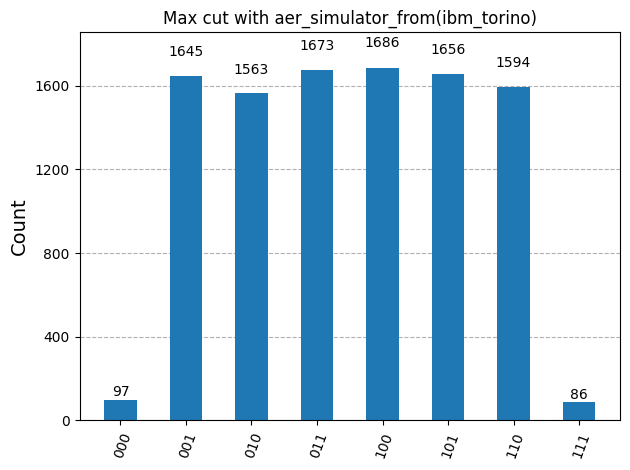

In [25]:
for noisy_fake_backend, circuit in zip(noisy_fake_backends[1:], qaoa_transpiled_list[1:]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

In [26]:
for noisy_fake_backend, counts_list_backend in zip(noisy_fake_backends, counts_list_backends):
    solutions_counts = [counts_list_backend.get(key, 0) for key in states_solutions]
    print(
        f"Probability of measuring a solution for {noisy_fake_backend.name} is {float(sum(solutions_counts)/SHOTS)}"
    )

Probability of measuring a solution for aer_simulator_from(ibm_brisbane) is 0.0
Probability of measuring a solution for aer_simulator_from(ibm_sherbrooke) is 0.0
Probability of measuring a solution for aer_simulator_from(ibm_torino) is 0.0


In [27]:
solutions_counts_noiseless = [counts_list.get(key, 0) for key in states_solutions]
print(
    f"Probability of measuring a solution for {generic_backend.name} is {float(sum(solutions_counts_noiseless)/SHOTS)}"
)

Probability of measuring a solution for generic_backend_5q is 0.0


## 3.2 Estimating errors using NEAT

In [28]:
results = []
for backend, opt_params in zip(noisy_fake_backends, opt_params_list):
    print(f"\nRunning on backend: {backend.name}")

    # Prepare the QAOA circuit with optimized parameters
    qaoa_neat = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
    qc = qaoa_neat.assign_parameters(opt_params)

    # Transpile the circuit
    qc_transpiled = generate_preset_pass_manager(
        optimization_level=3,
        basis_gates=backend.configuration().basis_gates[:n],
        seed_transpiler=seed,
    ).run(qc)
    # Use cost Hamiltonian as observable for Cliffordization
    obs = cost_hamiltonian
    analyzer = Neat(backend)
    clifford_pub = analyzer.to_clifford([(qc_transpiled, obs)])[0]

    # Construct observable from Clifford circuit
    state_clifford = Statevector.from_instruction(clifford_pub.circuit)
    obs_clifford = SparsePauliOp.from_operator(Operator(DensityMatrix(state_clifford).data))

    # Apply layout
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    isa_qc = pm.run(clifford_pub.circuit)
    isa_obs = obs_clifford.apply_layout(isa_qc.layout)

    # Prepare pubs and simulate
    pubs = [(isa_qc, isa_obs)]
    result_noiseless = (
        analyzer.ideal_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )
    noisy_results = (
        analyzer.noisy_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )

    # Store and print results
    results.append({"backend": backend.name, "noiseless": result_noiseless, "noisy": noisy_results})
    print(f"Ideal results on {backend.name}:\n{result_noiseless:.3f}")
    print(f"Noisy results on {backend.name}:\n{noisy_results:.3f}")


Running on backend: aer_simulator_from(ibm_brisbane)
Ideal results on aer_simulator_from(ibm_brisbane):
1.000
Noisy results on aer_simulator_from(ibm_brisbane):
0.922

Running on backend: aer_simulator_from(ibm_sherbrooke)
Ideal results on aer_simulator_from(ibm_sherbrooke):
1.000
Noisy results on aer_simulator_from(ibm_sherbrooke):
0.938

Running on backend: aer_simulator_from(ibm_torino)
Ideal results on aer_simulator_from(ibm_torino):
1.000
Noisy results on aer_simulator_from(ibm_torino):
0.942


# 4. Transpiler

## 4.1 Minimizing the two-qubit gates

In [29]:
# We select the `ibm_brisbane` backend
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# We print the results
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[101, 102], [92, 102]]
The errors introduced by each of the two-qubit operations are:
 [0.006, 0.009]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.052, 0.079]
The repetitions of each one of the two-qubit operations is:
 [9, 9]
The number of two-qubit operations in total:
 18
The total accumulated error by two-qubit operations is:
 0.131


## 4.2 Find the optimal layout

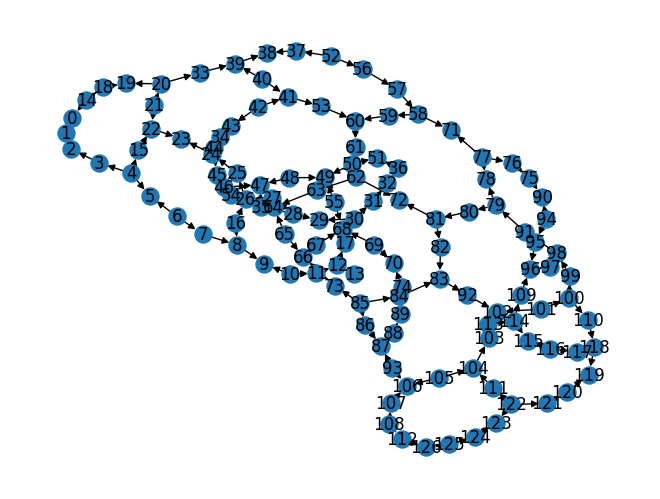

In [30]:
# We build a graph with the connectivity constraints of our backend that includes the two-qubit gate errors as weights in the edges
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(
                gate=two_qubit_gate, qubits=(edge[0], edge[1])
            ),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)

In [31]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """Remap node labels to a new sequence starting from 0 based on their order in original_labels."""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")

Physical qubit layout list:
 [101, 102, 92, 0, 1]

Original two-qubit gates list:
 [[101, 102], [92, 102]]

Remapped two-qubit gates list (in logical qubits):
 [[0, 1], [2, 1]]


### Exercise 4: Good Mapping

In [32]:
 def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    best_seed_transpiler = 0
    two_qubit_gate_count_seed_loop = 0
    
    # First we loop over 500 seeds and transpile the circuit
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        # ---- TODO : Task 5 ---
        # Goal: Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend looping from 0 to 500

        # TODO Use the `two_qubit_gate_errors_per_circuit_layout` function to count for the error of the transpile circuit
        result = two_qubit_gate_errors_per_circuit_layout(circuit_opt_seed, backend)
        # Handle different return formats
        if isinstance(result, tuple):
            current_error = result[0]  # Take the first element as error
            current_gate_count = result[1] if len(result) > 1 else circuit_opt_seed.count_ops().get('cx', 0) + circuit_opt_seed.count_ops().get('cz', 0)
        else:
            current_error = result
            current_gate_count = circuit_opt_seed.count_ops().get('cx', 0) + circuit_opt_seed.count_ops().get('cz', 0)

        # TODO Check if the error accounted above is smaller than min_err_acc_seed_loop. If so, assign the variables that this function returns
        if current_error < min_err_acc_seed_loop:
            min_err_acc_seed_loop = current_error
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler
            two_qubit_gate_count_seed_loop = current_gate_count

        # --- End of TODO ---

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )


# Execute the function
(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qaoa_circuit, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

Best transpiler seed: 276
Minimum accumulated two-qubit gate error: 0.052
Two-qubit gate count for best seed: 18
Best layout (first n logical qubits mapped to physical qubits):
 [20, 19, 18, 0, 1]


In [33]:
grade_lab2_ex5(finding_best_seed)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.7449625503744962
       x: [ 9.783e-01  1.081e+00 -1.879e-01  1.495e-01]
    nfev: 50
   maxcv: 0.0


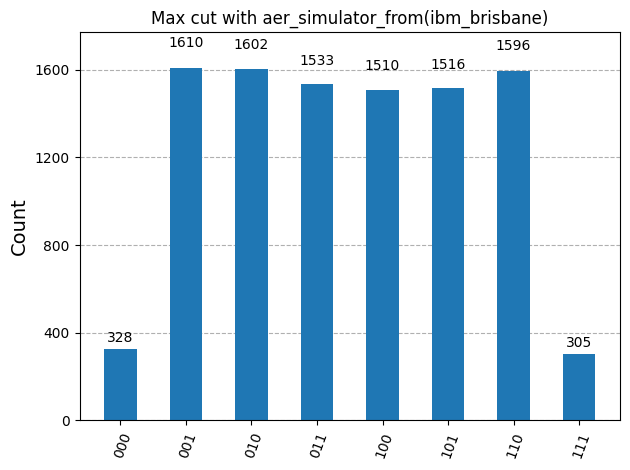

Probability of measuring a solution is 0.0
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.8462015379846202
       x: [ 9.990e-01  1.245e+00 -2.096e-02  2.881e-01]
    nfev: 34
   maxcv: 0.0


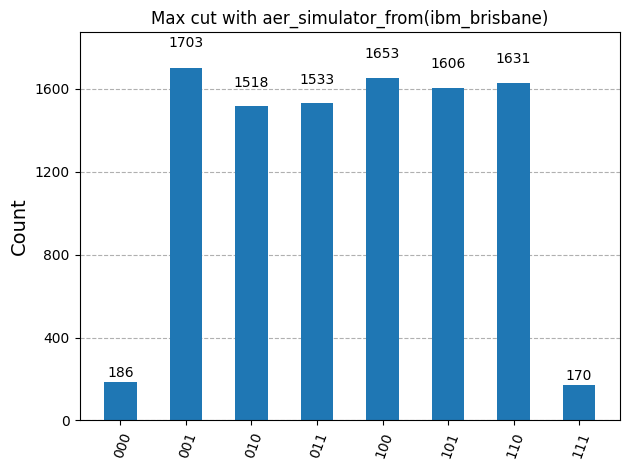

Probability of measuring a solution is 0.0


In [34]:
counts_list_transpiled_circuits = []
circuit_transpiled_list = [circuit_transpiled, circuit_opt_seed_loop]
opt_params_list_transpiled_circuits = []

for circuit in circuit_transpiled_list:
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list_transpiled_circuits.append(opt_params)
    counts_list_transpiled_circuit = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_transpiled_circuits.append(counts_list_transpiled_circuit)  # Fixed: append the correct variable
    
    # Handle missing keys safely
    solutions_counts = [counts_list_transpiled_circuit.get(key, 0) for key in states_solutions]
    print(f"Probability of measuring a solution is {float(sum(solutions_counts)/SHOTS)}")

# 5. Error Mitigation (EM)

## 5.1 Zero Noise Extrapolation (ZNE)

## Noise amplification

### Exercise 6a: Global Folding

In [35]:
def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Apply global circuit folding for Zero Noise Extrapolation (ZNE)."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")
    
    # We define the number of times we are going to "fold" the circuit
    n_repeat = (scale_factor - 1) // 2
    folded_circuit = QuantumCircuit(circuit.qubits, circuit.clbits)
    
    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """Remove all measurements from a quantum circuit."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr in qc.data:
            if instr.operation.name != "measure":
                clean_qc.append(instr.operation, instr.qubits)
        return clean_qc
    
    # Make a quantum circuit as a U (Unitary) by removing measurements, since measurements are not unitary
    clean_circuit = remove_all_measurements(circuit)
    
    # ---- TODO: Task 6a ----
    # Implement the global circuit folding. Use `QuantumCircuit.append` and `QuantumCircuit.inverse` functions
    # add U^† (inverse of clean_circuit) then U(clean_circuit) to the main circuit (folded_circuit)
    
    # Start with the original circuit
    folded_circuit.append(clean_circuit.to_instruction(), clean_circuit.qubits)
    
    # Add n_repeat pairs of U† followed by U
    for _ in range(n_repeat):
        # Add U† (inverse of clean_circuit)
        folded_circuit.append(clean_circuit.inverse().to_instruction(), clean_circuit.qubits)
        # Add U (clean_circuit)
        folded_circuit.append(clean_circuit.to_instruction(), clean_circuit.qubits)
    
    # --- End of TODO ---
    
    return folded_circuit

In [36]:
grade_lab2_ex6a(fold_global_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


### Exercise 6b: Local Folding

In [37]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Performs Zero-Noise Folding at the level of individual circuit instructions."""
    
    if scale_factor % 2 == 0:
        raise ValueError("scale must be an odd positive integer (1, 3, 5, ...)")
    
    # We define the number of times we are going to "fold" each instruction
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.qubits, circuit.clbits)
    
    if scale_factor == 1:
        return circuit
    else:
        for instruction in circuit.data:
            # ---- TODO: Task 6b ----
            # Implement the local circuit folding. Don't fold measurement gates!
            
            # Check if this is a measurement gate - if so, don't fold it
            if instruction.operation.name == "measure":
                # Just add the measurement as-is
                qc_folded.append(instruction.operation, instruction.qubits, instruction.clbits)
            else:
                # For non-measurement gates, apply local folding: G → G · G† · G
                
                # First, add the original gate G
                qc_folded.append(instruction.operation, instruction.qubits)
                
                # Then add n_repeat pairs of G† followed by G
                for _ in range(n_repeat):
                    # Add G† (inverse of the gate)
                    qc_folded.append(instruction.operation.inverse(), instruction.qubits)
                    # Add G (the original gate)
                    qc_folded.append(instruction.operation, instruction.qubits)
            
            # --- End of TODO ---
    
    return qc_folded

In [38]:
grade_lab2_ex6b(fold_local_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


## Extrapolation

In [39]:
def basic_zne(
    circuit,
    scales,
    backend,
    opt_params,
    observable,
):
    """Basic Zero Noise Extrapolation (ZNE) loop using local folding."""

    exp_vals = []
    xdata = np.array(scales)
    estimator = Estimator(mode=backend)

    for scale in scales:
        # Apply local folding
        folded = fold_local_circuit(circuit, scale)

        # Transpile for the backend
        basis_gates = backend.target.operation_names
        transpiled_folded = generate_preset_pass_manager(
            basis_gates=basis_gates, optimization_level=0, seed_transpiler=seed
        ).run(folded)
        pub = (
            transpiled_folded,
            observable.apply_layout(circuit.layout),
            opt_params,
        )
        # Evaluate the expectation value
        job = estimator.run([pub])
        results = job.result()[0]
        exp_vals.append(results.data.evs)

    return xdata, exp_vals, pub

In [40]:
scales = [1, 3, 5, 7, 9, 11, 13]
xdata, ydata, pub = basic_zne(
    qaoa_circuit_transpiled,
    scales,
    noisy_fake_backend,
    opt_params_list[num_backend],
    cost_hamiltonian,
)


 Extrapolation Method: LINEAR
⟨Z⟩ (ZNE Estimate): -0.394


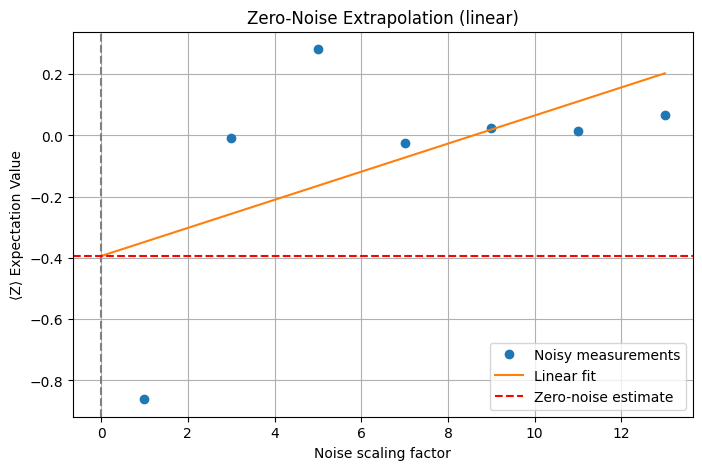


 Extrapolation Method: QUADRATIC
⟨Z⟩ (ZNE Estimate): -0.865


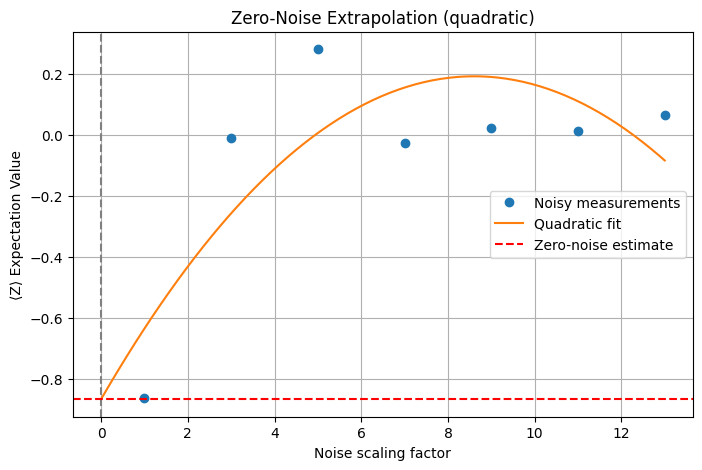


 Extrapolation Method: EXPONENTIAL
⟨Z⟩ (ZNE Estimate): -3.830


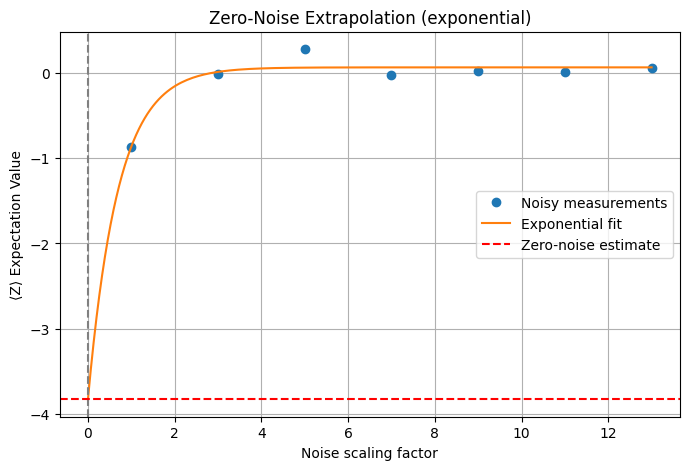

In [41]:
methods = ["linear", "quadratic", "exponential"]

for method in methods:
    print(f"\n Extrapolation Method: {method.upper()}")

    # Perform the extrapolation
    zero_val, fitted_vals, fit_params, fit_fn = zne_method(method=method, xdata=xdata, ydata=ydata)

    # Print the extrapolated expectation value
    print(f"⟨Z⟩ (ZNE Estimate): {zero_val:.3f}")

    # Plot the results
    plot_zne(xdata, fitted_vals, zero_val, fit_fn, fit_params, method)

In [42]:
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2148 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1543 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 800 participants have completed this lab
Lab 3: 0/5 exercises completed (0%)
    ✅ 523 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 268 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 2 participants have completed this lab
